<a href="https://colab.research.google.com/github/DJCordhose/mlops-drift/blob/main/notebooks/1-train-6-retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training


In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/mlops-drift/raw/main/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'../datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [3]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

'2.13.0'

In [4]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [5]:
tf.random.set_seed(42)

In [6]:
import numpy as np
np.__version__

'1.23.5'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [8]:
if IN_COLAB:
    !pip install -q lrcurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [25]:
# https://github.com/AndreasMadsen/python-lrcurve
from lrcurve import KerasLearningCurve

# Step 1: Choosing data set to train on

In [13]:
import pandas as pd

# original (old) data
df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
# new data
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show
# df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')


In [14]:
df.head(10)

,training,age,emergency_braking,braking_distance,power,miles,risk,group_name,group
0,0,41.951100,0,40.933328,122.238329,98.509765,3.700073,high,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.447873,medium,1
2,0,18.314649,1,41.587241,143.427269,76.862968,4.079834,high,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.087831,high,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.739299,high,0
5,0,29.506037,1,46.547745,139.820214,66.610999,3.130142,high,0
6,0,21.289385,1,40.666499,134.749599,63.146964,1.774027,medium,1
7,1,47.459483,0,35.168550,142.215391,123.385272,0.084924,low,2
8,1,20.573680,1,41.798826,114.677871,103.853842,-0.033755,low,2
9,0,24.639606,1,40.801391,162.457198,44.292386,2.456763,medium,1


In [15]:
df.describe()

,training,age,emergency_braking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.183617,0.901333
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481164,0.815705
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.289352,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.708085,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.386835,1.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874869,2.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.343054,2.000000


# Step 2: Training model

In [17]:
X = df.drop(['risk', 'group', 'group_name'], axis='columns').values

In [18]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([580, 488, 432]))

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 6), (300, 6), (1200,), (300,))

## Normalization

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [21]:
normalizer.adapt(X_train)

In [22]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

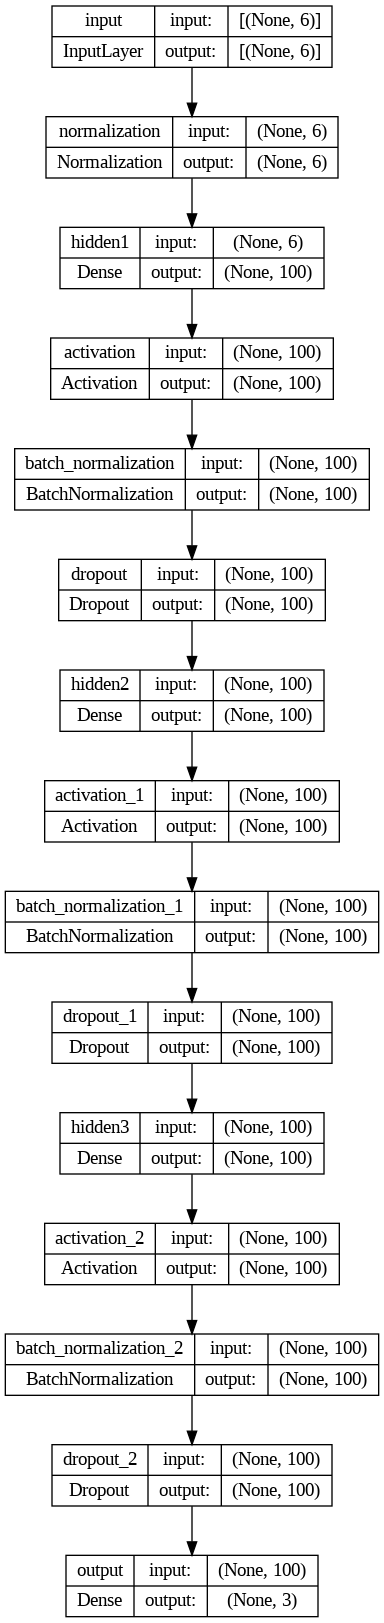

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [26]:
%%time

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 12.2 s, sys: 408 ms, total: 12.6 s
Wall time: 22.6 s


In [27]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 2ms/step - loss: 0.3806 - accuracy: 0.8683


(0.38059863448143005, 0.8683333396911621)

In [28]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 2ms/step - loss: 0.3782 - accuracy: 0.8800


(0.37819015979766846, 0.8799999952316284)

# Step 3: Saving Model

In [29]:
model.save('classifier.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model.save('classifier', save_format='tf')

In [31]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/saved_model.pb
./classifier/keras_metadata.pb
./classifier/variables/
./classifier/variables/variables.index
./classifier/variables/variables.data-00000-of-00001
./classifier/assets/
./classifier/fingerprint.pb


In [32]:
!ls -l

total 732
drwxr-xr-x 4 root root   4096 Oct  3 10:01 classifier
-rw-r--r-- 1 root root 337704 Oct  3 10:00 classifier.h5
-rw-r--r-- 1 root root 285244 Oct  3 10:01 classifier.tgz
-rw-r--r-- 1 root root 110682 Oct  3 09:59 model.png
drwxr-xr-x 1 root root   4096 Sep 29 13:23 sample_data
